In [1]:
# Paper or Website plots
PaperPlots = False # Paper and website have different formating. True for running for paper figures. False for running website plots.

In [2]:
'''

This code is part of the SIPN2 project focused on improving sub-seasonal to seasonal predictions of Arctic Sea Ice. 
If you use this code for a publication or presentation, please cite the reference in the README.md on the
main page (https://github.com/NicWayand/ESIO). 

Questions or comments should be addressed to nicway@uw.edu

Copyright (c) 2018 Nic Wayand

GNU General Public License v3.0


'''

'''
Plot forecast maps with all available models.
'''

%matplotlib inline
%load_ext autoreload
%autoreload
import matplotlib
if not PaperPlots:
    matplotlib.use('Agg')
import matplotlib.pyplot as plt
from collections import OrderedDict
import itertools
import numpy as np
import numpy.ma as ma
import pandas as pd
import struct
import os
import xarray as xr
import glob
import datetime
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import seaborn as sns
np.seterr(divide='ignore', invalid='ignore')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import json

from esio import EsioData as ed
from esio import ice_plot
from esio import import_data
from esio import metrics

import dask
import timeit
from dask.distributed import Client

# General plotting settings
sns.set_style('whitegrid')
sns.set_context("talk", font_scale=.8, rc={"lines.linewidth": 2.5})

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  F

In [5]:
def Update_Evaluation_Maps(PaperPlots = False):

#     client = Client(n_workers=8)
#     client

    ### Paper Figure Parameters

    # Time period options
    Last_valid_time = np.datetime64('2018-11-30') # last day in valid time space to include in analysis. 
    # Use  np.datetime64('2018-11-30') to reproduce Paper.

    # Domain options to use for calculating metrics over
    customDomainName = 'ArcticSeas' 
    # Options:
    # 'ArcticSeas' will use the Arctic Seas domain shown in Supplemental information
    # 'X' where X is a model name to use as the domain (i.e. X='rasmesrl' because it is the smallest domain)

    ### Code

    metrics_all = ['anomaly','mean','SIP']
    runType = 'forecast'
    variables = ['sic']

    # Only use 'sic' here
    cvar = variables[0]

    # Get path data
    E = ed.EsioData.load()
    grid_dir = E.grid_dir

    # Load in regional data
    ds_region = xr.open_dataset(os.path.join(grid_dir, 'sio_2016_mask_Update.nc'))

    # Define fig dir and make if doesn't exist (Hard coded here)
    if PaperPlots:
        fig_dir = os.path.join('/home/disk/sipn/nicway/Nic/figures', 'model', 'MME', cvar, 'BSS')
    else:
        fig_dir = os.path.join('/home/disk/sipn/nicway/public_html/sipn/figures/model/Eval')

    if not os.path.exists(fig_dir):
        os.makedirs(fig_dir)

    # Load from Zarr
    ds_m = xr.open_zarr(os.path.join(E.data_dir,'model/zarr',cvar+'.zarr'))

    # Select only initlizations from January 2018 to November 2018 (for GRL paper)
    if PaperPlots:
        ds_m = ds_m.where(ds_m.valid_end<=Last_valid_time, drop=True)
    # print("Warning: using ALL data")

    # Drop models we don't want
    ds_ALL = ds_m.where(ds_m.model!='dampedAnomaly', drop=True)

    def remove_list(X, L):
        for cl in L:
            X.remove(cl)

    # Get recent observations
    ds_81 = xr.open_mfdataset(E.obs['NSIDC_0081']['sipn_nc']+'_yearly/*.nc', concat_dim='time', autoclose=True, parallel=True)

    # Hack to decode strings
    ds_ALL['model'] = [s.decode("utf-8") for s in ds_ALL.model.values]

    # # Drop models that we don't evaluate (i.e. monthly means)
    exl_mods = ['awispin','nicosipn','szapirosipn']

    # Order models to plot in
    models_first = ['climatology','dampedAnomalyTrend','MME']
    X = list(ds_ALL.model.values)
    [X.remove(a) for a in models_first]
    model_plot_order = models_first + X
    model_plot_order.remove('Observed')
    # model_plot_order



    # Get custom domain mask if we have defined it (i.e. not None)
    if customDomainName=='ArcticSeas':
        customDomain = None
        fig_ext = '' # Figure extention to separte domain names
    else:
        customDomain = ds_ALL.sel(model=customDomainName).isel(fore_time=0,init_end=40).SIP.notnull()
        # Drop coods
        customDomain = customDomain.drop(['fore_time','init_end','init_start','valid_end','valid_start','model'])
        if customDomain.sum().values==0:
            raise ValueError("Warning: you need to choose a fore_time and init_end that has model data represenative of its extent")
        fig_ext = customDomainName+'_' # Figure extention to separte domain names

    # Calculate the IIEE (Integrated Ice Edge Error)
    l = []
    for cmod in ds_ALL.model.values: 
        c_SIP_IIEE = metrics.IIEE(da_mod=ds_ALL.sel(model=cmod)['mean'], 
                                          da_obs=ds_ALL.sel(model='Observed')['mean'], 
                                          region=ds_region, 
                                          testplots=False,
                                          customDomain=customDomain)
        c_SIP_IIEE.coords['model'] = cmod
        l.append(c_SIP_IIEE)
    SIP_IIEE = xr.concat(l, dim='model')
    SIP_IIEE

    # For SIP, calculate the Brier Skill Score for panArctic 
    # BS = (SIP_model - SIP_observed)^2
    #
    l = []
    for cmod in ds_ALL.model.values: 
        c_SIP_BSS = metrics.BrierSkillScore(da_mod_sip=ds_ALL.sel(model=cmod).SIP, 
                                          da_obs_ip=ds_ALL.sel(model='Observed').SIP, 
                                          region=ds_region, 
                                          testplots=False,
                                          customDomain=customDomain)
        c_SIP_BSS.coords['model'] = cmod
        l.append(c_SIP_BSS)
    SIP_BSS = xr.concat(l, dim='model')





    def add_subplot_title(cmod, E, ax=None, BSS_val=''):
        if cmod in E.model.keys():
            ax.set_title((E.model[cmod]['model_label']).rstrip('*')+'\n('+BSS_val+')')
        else:
            ax.set_title(cmod)

    # add missing info for climatology
    E.model_color['climatology'] = (0,0,0)
    E.model_linestyle['climatology'] = '--'
    E.model_marker['climatology'] = '*'
    E.model['climatology'] = {'model_label':'Climatology\nTrend'}

    E.model_color['climo10yrs'] = (0,0,0)
    E.model_linestyle['climo10yrs'] = '-'
    E.model_marker['climo10yrs'] = ''
    E.model['climo10yrs'] = {'model_label':'Climatology\nPast 10 Yrs'}

    # Aggregate over space (x,y), including all pixels in valid Arctic seas (masked above with BrierSkillScore())
    BSS_agg = SIP_BSS.mean(dim=['x','y'])
    BSS_agg.load() # Compute and load result into memory

    ### At what lead time is the MME significantly (95%) better than the Damped Anomaly?

    from scipy import stats

    model_1 = 'MME'
    model_2 = 'dampedAnomalyTrend'
    alphaval = 0.05 # 95%

    t_all=[]
    p_all=[]
    cv_all=[]
    for ft in np.arange(0,BSS_agg.fore_time.size):
        x = BSS_agg.sel(model=model_1).isel(fore_time=ft)
        y = BSS_agg.sel(model=model_2).isel(fore_time=ft)

        x = x.where(x.notnull() & y.notnull(), drop=True)
        y = y.where(x.notnull() & y.notnull(), drop=True)

        df = x.size + y.size -2

        t, p = stats.ttest_ind(x, y, equal_var=False)
        cv = stats.t.ppf(1.0 - alphaval, df)

        t_all.append(t)
        p_all.append(p)
        cv_all.append(cv)


    plt.figure()
    plt.plot(BSS_agg.fore_time.values.astype('timedelta64[D]').astype(int)/7,
            abs(np.array(t_all)),'-k*', label='t-value')
    plt.plot(BSS_agg.fore_time.values.astype('timedelta64[D]').astype(int)/7,
            cv_all,'-r*', label='critical t-value')
    plt.ylabel('t-value')
    plt.legend()


    plt.figure()
    plt.plot(BSS_agg.fore_time.values.astype('timedelta64[D]').astype(int)/7,
            p_all,'-k*',label='p value')
    plt.plot(BSS_agg.fore_time.values.astype('timedelta64[D]').astype(int)/7,
            np.ones(len(p_all))*alphaval,'-r*',label='Alpha p value')
    plt.ylabel('p-value')
    plt.legend()

    # Read off what lead time in weeks where the black line crosses the red line

    # central_extent = [-3850000*0.6, 3725000*0.6, -5325000*0.45, 5850000*0.45] # (x0, x1, y0, y1
    # (f, axes) = ice_plot.multi_polar_axis(ncols=2, nrows=1, Nplots=2, 
    #                                       extent=central_extent, central_longitude=0)
    # f.set_size_inches(18.5, 10.5)

    # # Get Observed mean sea ice edge location mean(SIC in sept) > 0.15
    # # obs_SIP_OLD = ds_81['sic'].sel(time=slice(start_date_map,end_date_map)).mean(dim='time')>=0.15
    # # Fill in pole hole
    # # obs_SIP_OLD = obs_SIP_OLD.where(obs_SIP_OLD.hole_mask==0, other=1)

    # p1 = obs_SIP.plot.pcolormesh(ax=axes[0], x='lon', y='lat', 
    #                                       transform=ccrs.PlateCarree(),
    #                                       add_colorbar=False,
    #                                       cmap=cmap_c,
    #                                       vmin=c_vmin, vmax=c_vmax)
    # # ice_plot.remove_small_contours(po, thres=10**6)

    # obs_SIP_contour = obs_SIP.where((obs_SIP.lon < 179.1))

    # po = obs_SIP_contour.plot.contour(ax=axes[0], x='lon', y='lat',
    #                               transform=ccrs.PlateCarree(), #.NorthPolarStereo(central_longitude=-45),
    #                               colors=('k'),
    #                               linewidths=[1],
    #                               levels=[0.5])
    # # ice_plot.remove_small_contours(po, thres=10**6)

    ### Plot BS spatial plots valid for Summer months (Figure 3)

    # Remove some select models
    enough_init = model_plot_order.copy()
    [enough_init.remove(a) for a in exl_mods]
    print(enough_init)

    # Define lead time to plot
    week_lead_time = 4

    period_dict = {'June':[np.datetime64('2018-06-01'),np.datetime64('2018-07-01')],
                  'July':[np.datetime64('2018-07-01'),np.datetime64('2018-08-01')],
                  'August':[np.datetime64('2018-08-01'),np.datetime64('2018-09-01')],
                  'September':[np.datetime64('2018-09-01'),np.datetime64('2018-10-01')]}

    for period in period_dict:
        print(period)
        start_date_map = period_dict[period][0]
        end_date_map = period_dict[period][1]    

        # Select time slice of valid
        BS_Sept = SIP_BSS.where( (SIP_BSS.valid_start>=start_date_map) & 
                      (SIP_BSS.valid_start<=end_date_map), drop=True)

        # Average over valid time 
        SIP_BSS_init_avg = BS_Sept.sel(model=enough_init).mean(dim='init_end')

        sns.set_context("talk", font_scale=.8, rc={"lines.linewidth": 2.5})

        # Set up color maps
        cmap_c = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white","orange","red","#990000"], N=10)
        cmap_c.set_bad(color = 'lightgrey')
        c_label = 'BS (0=best, 1=worst)'
        c_vmin = 0
        c_vmax = 1

        for ft in [SIP_BSS_init_avg.fore_time.values[week_lead_time]]:  

            # Grab current lead time
            c_ft_ds = SIP_BSS_init_avg.sel(fore_time=ft)

            # Drop models without any data
            c_ft_ds = c_ft_ds.where(c_ft_ds.notnull().sum(dim=['x','y'])>0, drop=True)

            nrows = np.int(np.ceil(np.sqrt(c_ft_ds.model.size))) - 1
            ncols = int(np.ceil(c_ft_ds.model.size/nrows))
            Nplots = c_ft_ds.model.size + 1
            #print(Nplots)

            # New Plot
            central_extent = [-3850000*0.6, 3725000*0.6, -5325000*0.45, 5850000*0.45] # (x0, x1, y0, y1
            (f, axes) = ice_plot.multi_polar_axis(ncols=ncols, nrows=nrows, Nplots=Nplots, 
                                                  extent=central_extent, central_longitude=0)


    #         # Get Observed mean sea ice edge location mean(SIC in sept) > 0.15
    #         obs_SIP = ds_81['sic'].sel(time=slice(start_date_map,end_date_map)).mean(dim='time')>=0.15
    #         # Fill in pole hole
    #         obs_SIP = obs_SIP.where(obs_SIP.hole_mask==0, other=1)

            obs_SIP = ds_ALL.sel(model='Observed').SIP

            # Select time slice of valid
            obs_SIP = obs_SIP.where( (obs_SIP.valid_start>=start_date_map) & 
                          (obs_SIP.valid_start<=end_date_map), drop=True)

            # Average over valid time 
            obs_SIP = obs_SIP.mean(dim='init_end').sel(fore_time=ft)

            for (i, cmod) in enumerate(c_ft_ds.model.values):
                if cmod in c_ft_ds.model.values:
                    # Plot
                    add_subplot_title(cmod, E, ax=axes[i])
                    p = c_ft_ds.sel(model=cmod).plot.pcolormesh(ax=axes[i], x='lon', y='lat', 
                                          transform=ccrs.PlateCarree(),
                                          add_colorbar=False,
                                          cmap=cmap_c,
                                          vmin=c_vmin, vmax=c_vmax)

                    # Need to clip obs so contour handles wrap around 180 correctly
                    obs_SIP_contour = obs_SIP.where((obs_SIP.lon < 179.1))
                    po = obs_SIP_contour.plot.contour(ax=axes[i], x='lon', y='lat',
                                          transform=ccrs.PlateCarree(), #.NorthPolarStereo(central_longitude=-45),
                                          colors=('k'),
                                          linewidths=[1],
                                          levels=[0.5])

                    add_subplot_title(cmod, E, ax=axes[i], BSS_val='{0:.3f}'.format(c_ft_ds.sel(model=cmod).mean(dim=['x','y']).load().item()))

            # Make pretty
            cbar_ax = f.add_axes([0.2, 0.05, .5, 0.04]) #  [left, bottom, width, height] w
            cbar = f.colorbar(p, cax=cbar_ax, label=c_label, orientation='horizontal')
            cbar.set_ticks(np.arange(-1,1.1,0.2))

            # Set title of all plots
            lead_time_days = str(ft.astype('timedelta64[D]').astype(int))
            #print(lead_time_days)

            if not PaperPlots: # only add for website plots
                cbar_ax.text(0.35, 1.1, 'Wayand et al. (2019)', fontsize=12)

            valid_start_str = pd.to_datetime(start_date_map).strftime('%Y-%m-%d')
            valid_end_str = pd.to_datetime(end_date_map).strftime('%Y-%m-%d')

            # Save to file
            f_out = os.path.join(fig_dir,fig_ext+'BSS_Avg_Valid_'+valid_start_str+'_to_'+valid_end_str+'_'+lead_time_days.zfill(3)+'_day_lead_time.png')
            f.savefig(f_out,bbox_inches='tight', dpi=300)



    ### Plot Brier Score vs lead time


    min_N_samples = 10 # Min number of samples to allow for mean
    BSS_agg_init = BSS_agg.mean(dim='init_end')
    sns.set_style("whitegrid")

    sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 2.5})

    # Get sample size of for each lead time
    for_sample = BSS_agg.sel(model='MME').notnull().sum(dim='init_end')
    for_sample

    # Use threshold of sample size to cut off lead times
    max_lead = for_sample.where(for_sample>=min_N_samples,drop=True).fore_time.max().values.astype('timedelta64[D]').astype(int)/7

    f = plt.figure(figsize=(10,10))
    NM = 10
    ax1 = plt.subplot2grid((NM, NM), (0, 0), colspan=NM, rowspan=NM-1)
    ax2 = plt.subplot2grid((NM, NM), (NM-1, 0), colspan=NM, rowspan=1)

    for cmod in model_plot_order:
        if cmod in exl_mods:
            continue
        # Get model plotting specs
        cc = E.model_color[cmod]
        cl = E.model_linestyle[cmod]
        cm = E.model_marker[cmod]
        if cmod=='rasmesrl':
            cflag = '*'
        else:
            cflag = ''

        if cmod in ['MME','dampedAnomalyTrend','climatology']:
            lw=5
        else:
            lw = 2

        ax1.plot(BSS_agg_init.fore_time.values.astype('timedelta64[D]').astype(int)/7,
                BSS_agg_init.sel(model=cmod).values, label=E.model[cmod]['model_label'].rstrip('*')+cflag,
                color=cc,
                linestyle=cl,
                linewidth=lw,
                marker=cm)
    ax1.legend(loc='lower right', bbox_to_anchor=(1.4, 0))
    ax1.set_ylabel('Pan-Arctic BS (-)')
    ax1.set_xlim([-0.5,max_lead])
    ax1.set_xticklabels([''])

    # second axis
    ax2.plot(for_sample.fore_time.values.astype('timedelta64[D]').astype(int)/7,
             for_sample.values, '-ko')
    ax2.set_ylabel('#\nweeks')
    ax2.set_xlabel('Lead time (Weeks)')
    ax2.set_xlim(ax1.get_xlim());

    ax2.set_ylim([0,for_sample.max()+5]);
    ax2.set_yticks(np.arange(0,for_sample.max()+5,15));

    if not PaperPlots: # only add for website plots
        ax1.text(17, 0.025, 'Wayand et al. (2019)', fontsize=12)

    # Save to file
    f_out = os.path.join(fig_dir,fig_ext+'BSS_by_lead_time_PanArctic.png')
    f.savefig(f_out,bbox_inches='tight', dpi=300)
    
    
    
    

    ### Plot Brier Score vs lead time (Figure 1)
    print(BSS_agg_init.model.values)
    mean_models = []

    min_N_samples = 10 # Min number of samples to allow for mean
    BSS_agg_init = BSS_agg.mean(dim='init_end')
    sns.set_style("whitegrid")

    sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 2.5})

    # Get sample size of for each lead time
    for_sample = BSS_agg.sel(model='MME').notnull().sum(dim='init_end')

    # Use threshold of sample size to cut off lead times
    max_lead = for_sample.where(for_sample>=min_N_samples,drop=True).fore_time.max().values.astype('timedelta64[D]').astype(int)/7

    f = plt.figure(figsize=(15,10))
    NM = 10
    ax1 = plt.subplot2grid((NM, NM), (0, 0), colspan=NM, rowspan=NM-1)
    ax2 = plt.subplot2grid((NM, NM), (NM-1, 0), colspan=NM, rowspan=1)

    for cmod in model_plot_order:
        if cmod in exl_mods:
            continue
        # Get model plotting specs
        cc = E.model_color[cmod]
        cl = E.model_linestyle[cmod]
        cm = E.model_marker[cmod]
        if cmod=='rasmesrl':
            cflag = '*'
        else:
            cflag = ''

        if cmod in ['MME','dampedAnomalyTrend','climatology']:
            lw=5
        else:
            lw = 2
            mean_models.append(cmod)
            
        ax1.plot(BSS_agg_init.fore_time.values.astype('timedelta64[D]').astype(int)/7,
                BSS_agg_init.sel(model=cmod).values, label=E.model[cmod]['model_label'].rstrip('*')+cflag,
                color=cc,
                linestyle=cl,
                linewidth=lw,
                marker=cm)
        
    # Plot the mean of BS across models 
    ax1.plot(BSS_agg_init.fore_time.values.astype('timedelta64[D]').astype(int)/7,
                BSS_agg_init.sel(model=mean_models).mean(dim='model').values, label='BS Mean',
                color='r',
                linestyle='-',
                linewidth=2,
                marker='d')
        
    ax1.legend(loc='lower right', bbox_to_anchor=(1.285, -0.1))
    ax1.set_ylabel('Pan-Arctic BS (-)')
    ax1.set_xlim([-0.5,max_lead])
    ax1.set_xticklabels([''])
    ax1.set_ylim([0.02,0.11])

    # second axis
    ax2.plot(for_sample.fore_time.values.astype('timedelta64[D]').astype(int)/7,
             for_sample.values, '-ko')
    ax2.set_ylabel('#\nweeks   ')
    ax2.set_xlabel('Lead time (Weeks)')
    ax2.set_xlim(ax1.get_xlim());

    ax2.set_ylim([0,for_sample.max()+5]);
    ax2.set_yticks(np.arange(0,for_sample.max()+5,15));

    if not PaperPlots: # only add for website plots
        ax1.text(17, 0.025, 'Wayand et al. (2019)', fontsize=12)

    # Save to file
    f_out = os.path.join(fig_dir,fig_ext+'BSS_by_lead_time_PanArctic_New.png')
    f.savefig(f_out,bbox_inches='tight', dpi=200)
    
    
    

    ### Plot the IIEE with lead time (SI)

    SIP_IIEE.load()

    min_N_samples = 10 # Min number of samples to allow for mean
    SIP_IIEE_init = SIP_IIEE.mean(dim='init_end')
    sns.set_style("whitegrid")

    sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 2.5})

    # Get sample size of for each lead time
    for_sample = SIP_IIEE.sel(model='MME').notnull().sum(dim='init_end')

    # Use threshold of sample size to cut off lead times
    max_lead = for_sample.where(for_sample>=min_N_samples,drop=True).fore_time.max().values.astype('timedelta64[D]').astype(int)/7

    f = plt.figure(figsize=(10,10))
    NM = 10
    ax1 = plt.subplot2grid((NM, NM), (0, 0), colspan=NM, rowspan=NM-1)
    ax2 = plt.subplot2grid((NM, NM), (NM-1, 0), colspan=NM, rowspan=1)

    for cmod in model_plot_order:
        if cmod in exl_mods:
            continue
        # Get model plotting specs
        cc = E.model_color[cmod]
        cl = E.model_linestyle[cmod]
        cm = E.model_marker[cmod]
        if cmod=='rasmesrl':
            cflag = '*'
        else:
            cflag = ''
        if cmod in ['MME','dampedAnomalyTrend','climatology']:
            lw=5
        else:
            lw = 2

        ax1.plot(SIP_IIEE_init.fore_time.values.astype('timedelta64[D]').astype(int)/7,
                SIP_IIEE_init.sel(model=cmod).values, label=E.model[cmod]['model_label'].rstrip('*')+cflag,
                color=cc,
                linestyle=cl,
                linewidth=lw,
                marker=cm)
    ax1.legend(loc='lower right', bbox_to_anchor=(1.4, 0))
    ax1.set_ylabel('IIEE (Millions of km$^2$)')
    ax1.set_xlim([-0.5,max_lead])
    ax1.set_xticklabels([''])

    # second axis
    ax2.plot(for_sample.fore_time.values.astype('timedelta64[D]').astype(int)/7,
             for_sample.values, '-ko')
    ax2.set_ylabel('#\nweeks')
    ax2.set_xlabel('Lead time (Weeks)')
    ax2.set_xlim(ax1.get_xlim());

    ax2.set_ylim([0,for_sample.max()+5]);
    ax2.set_yticks(np.arange(0,for_sample.max()+5,15));

    if not PaperPlots: # only add for website plots
#        ax1.text(np.datetime64('2018-01-01'), 0.025, 'Wayand et al. (in review)', fontsize=12)
        ax1.text(7, 0.25, 'Wayand et al. (2019)', fontsize=12)


    # Save to file
    f_out = os.path.join(fig_dir,fig_ext+'IIEE_by_lead_time_PanArctic.png')
    f.savefig(f_out,bbox_inches='tight', dpi=200)







    ### Define DA methods for each model

    # copy past info from Table 1
    DA_dict = {
    'modcansipns_3':'SIC (NG)', 
    'modcansipns_4':'SIC (NG)',
    'ecmwfsipn':'SIC (3DVAR)', 
    'ecmwf':'SIC (3DVAR)',
    'yopp':'SIC (3DVAR)',
    'gfdlsipn':'No Sea Ice DA',
    'metreofr':'SIC (EnKF)',
    'szapirosipn':'No Sea Ice DA',
    'ncep-exp-bias-corr':'SIC (NG)',
    'noaasipn':'SIC (NG)',
    'usnavysipn':'SIC (3DVAR)',
    'usnavyncep':'SIC (3DVAR)',
    'usnavygofs':'SIC (3DVAR)',
    'rasmesrl':'SIC (DI), SIT* (DI)',
    'uclsipn':'No Sea Ice DA',
    'ukmetofficesipn':'SIC (3DVAR)',
    'ukmo':'SIC (3DVAR)',
    'ncep':'SIC (NG)',
    'kma':'SIC (3DVAR)'
    }

    # Add models
    DA_dict['climatology'] = 'No Sea Ice DA'
    DA_dict['dampedAnomalyTrend'] = 'SIC (DI)'
    DA_dict['MME'] = 'MME'
    DA_dict

    DA_options = sorted(list(set(DA_dict.values())))
    dict(zip(DA_options,np.arange(len(DA_options))))

    #DA_options = [DA_options[1],  DA_options[4], DA_options[5], DA_options[7], DA_options[2], DA_options[3], DA_options[6],DA_options[0],] # Reorder from simple to complex
    DA_options = [DA_options[1],  DA_options[3], DA_options[4], DA_options[6], DA_options[2], DA_options[5],DA_options[0],] # Reorder from simple to complex
    
    DA_options_i = np.arange(len(DA_options))
    DA_options_dict = dict(zip(DA_options,DA_options_i))
    DA_options_dict

    ### Plot BS by DA method (Figure 4)

    # In place a multi lead times

    # Lead times to plot
    leads2plot = [0,1,2,3,4] # indices
    sns.set_style("whitegrid")

    sns.set_context("talk", font_scale=1, rc={"lines.linewidth": 2.5})
    f, axes = plt.subplots(1, 1, figsize=(9, 5))

    for cmod in BSS_agg.model.values:
        if cmod in DA_dict.keys():
            # Get model plotting specs
            cc = E.model_color[cmod]
            cl = E.model_linestyle[cmod]
            cm = E.model_marker[cmod]
            if cmod=='MME':
                lw=4
            else:
                lw=2

            BSS_init = BSS_agg.sel(model=cmod).isel(fore_time=leads2plot).mean(dim='init_end').load()

            #rand_jit = np.random.randint(-100,100)/1000*2
            c_x = np.linspace(DA_options_dict[DA_dict[cmod]],
                              DA_options_dict[DA_dict[cmod]]+0.75,
                              len(leads2plot))
            #print(c_x)

            axes.plot(c_x, 
                    BSS_init.values,
                    color=cc,
                    linestyle='-',
                    linewidth=lw,
                    marker=cm,
                    label=E.model[cmod]['model_label'].rstrip('*'))
        else:
            print(cmod,"not in dict")
    axes.set_xticks(DA_options_i)
    axes.set_xticklabels(DA_options, rotation='45', ha='right')

    plt.legend(loc='lower right', bbox_to_anchor=(1.36, -.25))
    plt.ylabel('Pan-Arctic BS (-)')

    if not PaperPlots: # only add for website plots
        axes.text(4.2, 0.081, 'Based on Wayand et al. (2019)', fontsize=12)

    # Save to file
    f_out = os.path.join(fig_dir,fig_ext+'BSS_week_Multi_by_DA_Type.png')
    f.savefig(f_out,bbox_inches='tight', dpi=200)



    ### Plot BS by initialization time (Figure 2)

    sns.set_style("whitegrid")

    for ft_i in [4]:
        BSS_agg_fore = BSS_agg.isel(fore_time=ft_i)

        sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 2.5})
        f = plt.figure(figsize=(10,10))
        for cmod in model_plot_order:
            # Get model plotting specs
            cc = E.model_color[cmod]
            cl = E.model_linestyle[cmod]
            cm = E.model_marker[cmod]
            if cmod in ['MME','dampedAnomalyTrend','climatology']:
                lw=5
            else:
                lw = 2
            if BSS_agg_fore.sel(model=cmod).notnull().sum().values==0:
                continue # Don't plot
            plt.plot(BSS_agg_fore.init_end.values,
                    BSS_agg_fore.sel(model=cmod).values, label=E.model[cmod]['model_label'].rstrip('*'),
                    color=cc,
                    linestyle=cl,
                    linewidth=lw,
                    marker=cm)
        plt.legend(loc='lower right', bbox_to_anchor=(1.4, -0.1))
        plt.ylabel('Pan-Arctic BS (-)')
        plt.xlabel('Initialization date')
        #plt.title(BSS_agg_fore.fore_time.values.astype('timedelta64[D]').astype(int))
        f.autofmt_xdate()


        if not PaperPlots: # only add for website plots
            plt.text(np.datetime64('2018-01-01'), 0.163, 'Based on Wayand et al. (2019)', fontsize=12)
        # Save to file
        f_out = os.path.join(fig_dir,fig_ext+'BSS_by_init_time_'+str(BSS_agg_fore.fore_time.values.astype('timedelta64[D]').astype(int))+'_days.png')
        f.savefig(f_out,bbox_inches='tight', dpi=200)

        print("Finished Eval_Weekly")

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/distributed/bokeh/core.py:57: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn('\n' + msg)


['climatology', 'dampedAnomalyTrend', 'MME', 'climo10yrs', 'ecmwf', 'ecmwfsipn', 'fgoalssipn', 'gfdlsipn', 'kma', 'metreofr', 'ncep', 'rasmesrl', 'ukmetofficesipn', 'ukmo', 'usnavygofs', 'usnavyncep', 'usnavysipn', 'yopp']
June


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


July
August
September


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


['MME' 'Observed' 'awispin' 'climatology' 'climo10yrs'
 'dampedAnomalyTrend' 'ecmwf' 'ecmwfsipn' 'fgoalssipn' 'gfdlsipn' 'kma'
 'metreofr' 'ncep' 'nicosipn' 'rasmesrl' 'szapirosipn' 'ukmetofficesipn'
 'ukmo' 'usnavygofs' 'usnavyncep' 'usnavysipn' 'yopp']


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Observed not in dict
awispin not in dict
climo10yrs not in dict
fgoalssipn not in dict
nicosipn not in dict


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Finished Eval_Weekly


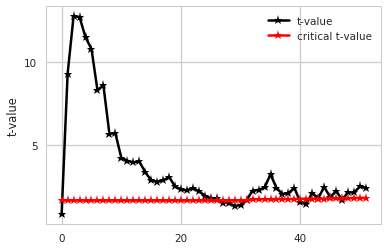

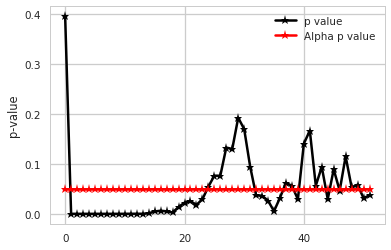

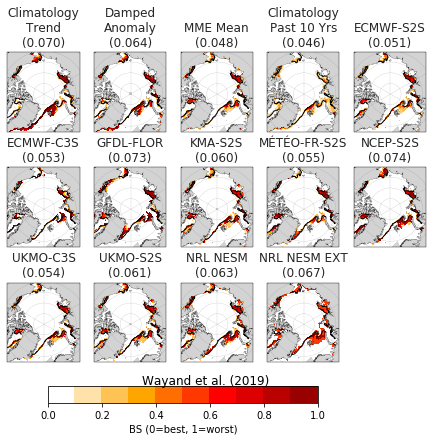

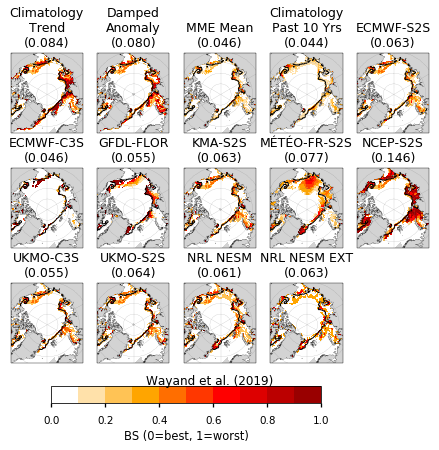

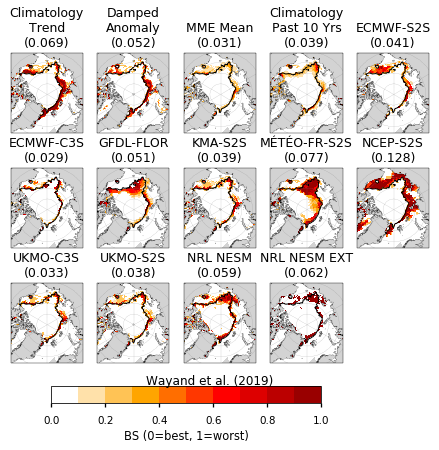

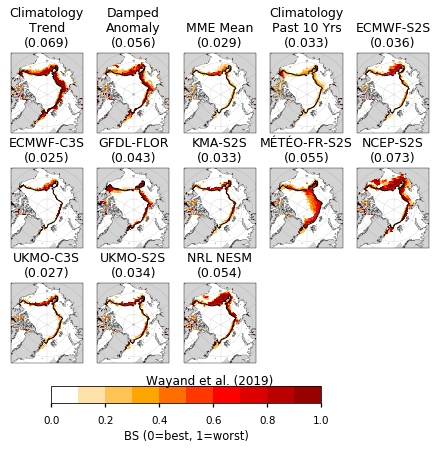

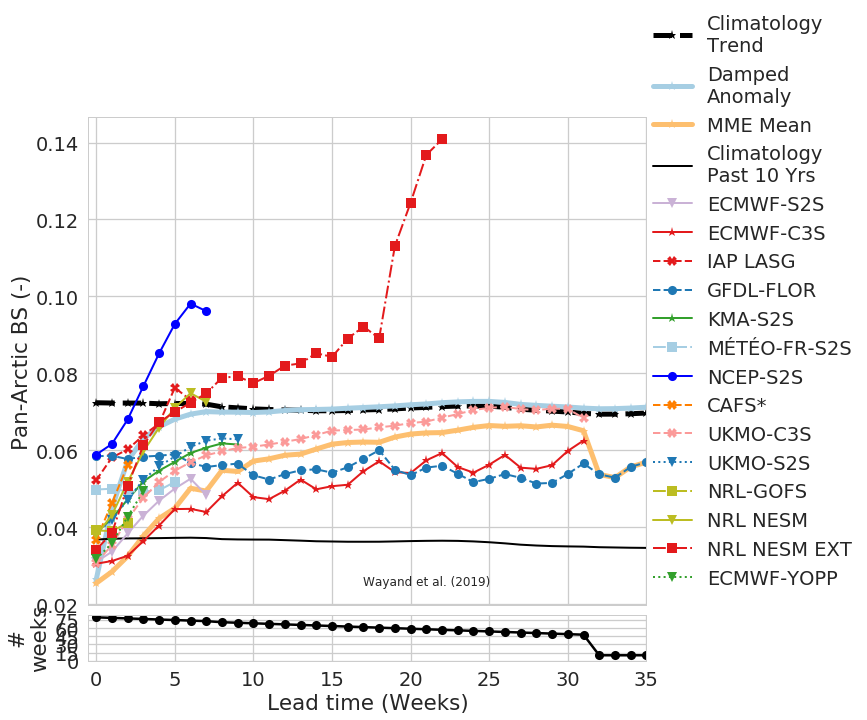

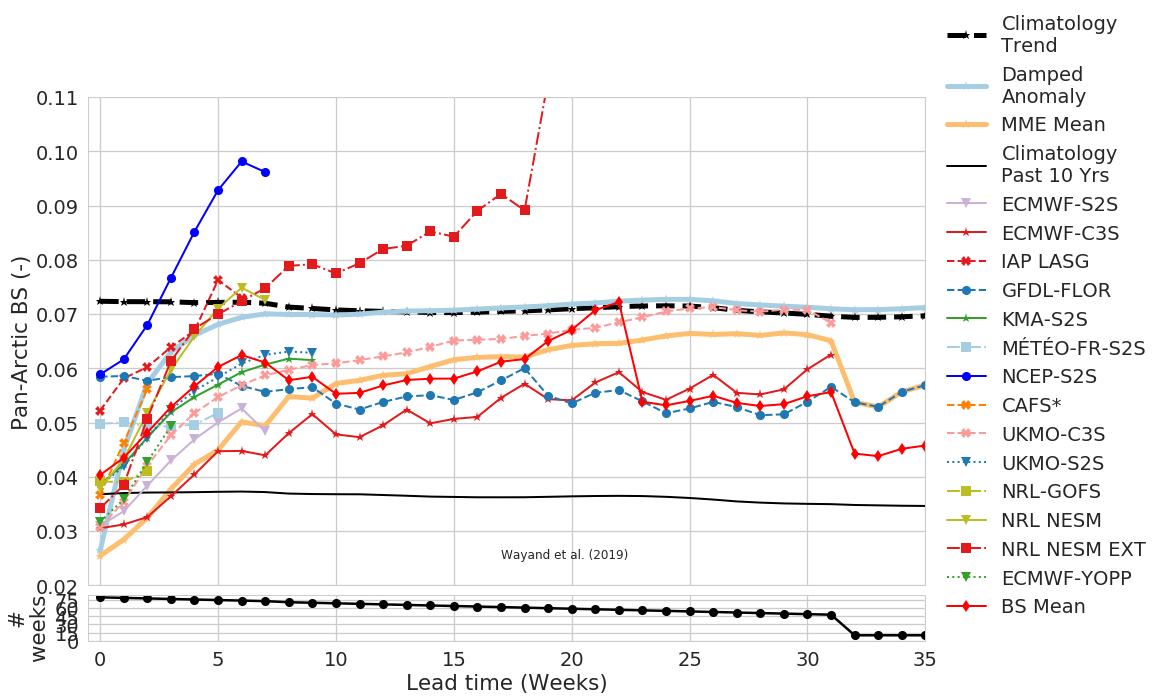

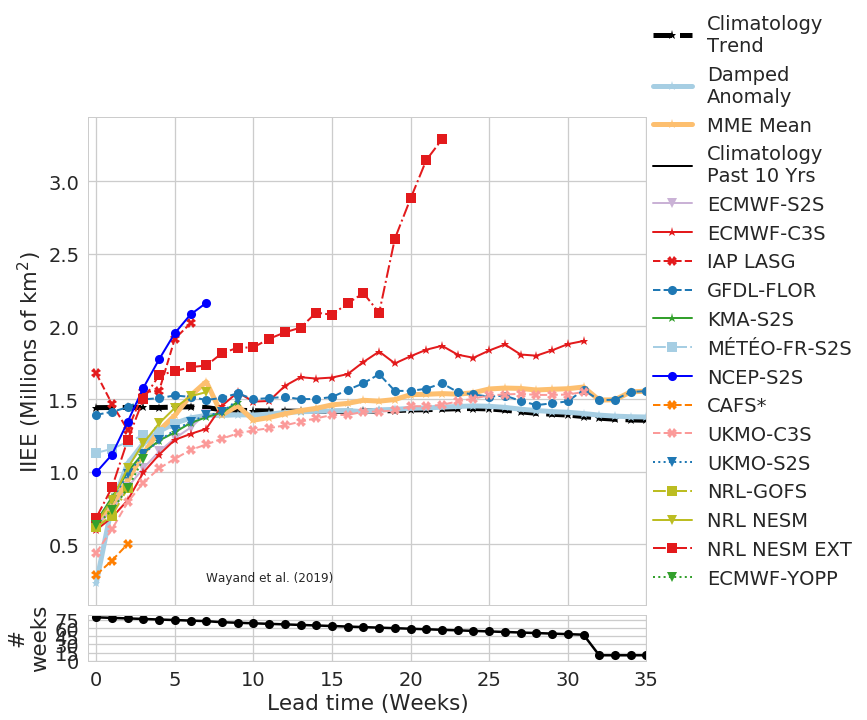

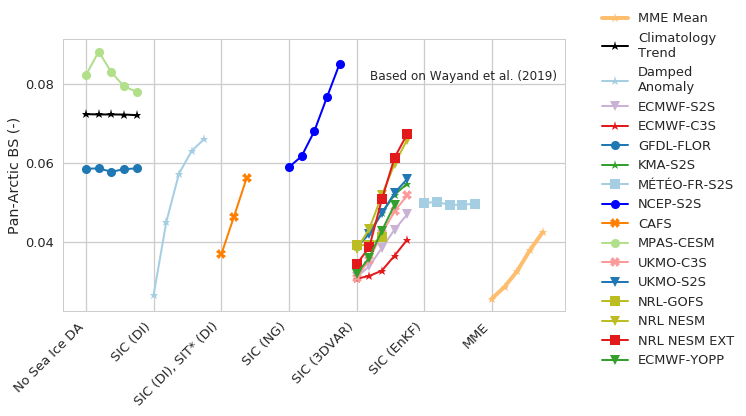

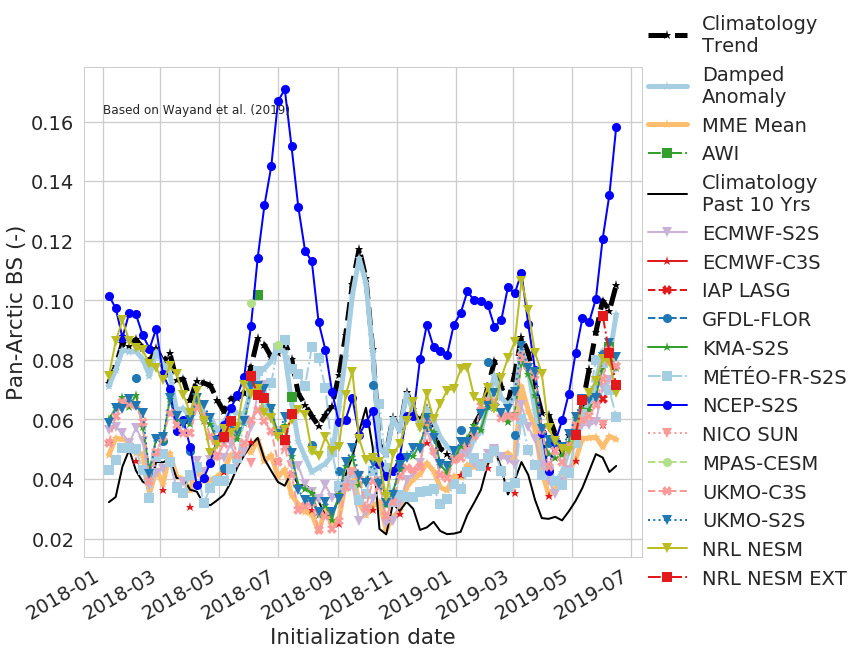

In [6]:
if __name__ == '__main__':
    # Start up Client
    client = Client(n_workers=8)
    
    # Call function
    Update_Evaluation_Maps(PaperPlots)

In [5]:
PaperPlots

False